In [1]:
import bs4
import os
import tiktoken
import numpy as np
from dotenv import load_dotenv

# Load from .env if you use one
load_dotenv()
os.environ["USER_AGENT"] = (
    "Mozilla/5.0 (compatible; RAG-TutorialBot/1.0; +https://yourwebsite.com/bot)"
)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_huggingface import HuggingFaceEmbeddings

In [29]:
LANGSMITH_PROJECT = "rag-virtual-assistant-course"

# INDEXING

In [30]:
# Load documents from the web
loader = WebBaseLoader(
    web_paths=[
        "https://www.reuters.com/world/europe/greece-ask-eu-fiscal-leeway-defence-spending-minister-says-2025-04-29/",
        "https://www.ekathimerini.com/economy/1264299/moodys-upgrade-of-the-greek-economy-is-significant-says-govt-spox/",
    ],
    bs_kwargs={
        # Optional: you can remove `bs_kwargs` if the websites don't need specific filtering
        "parse_only": bs4.SoupStrainer(
            ["article", "body", "main", "section", "div", "p"]
        )
    },
)
docs = loader.load()

# Split documents into manageable chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Check for available API keys
openai_key = os.getenv("OPENAI_API_KEY")
groq_key = os.getenv("GROQ_API_KEY")

# Create vectorstore with OpenAI embeddings
if os.getenv("OPENAI_API_KEY"):
    embedder = OpenAIEmbeddings()
else:
    embedder = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )

vectorstore = Chroma.from_documents(documents=splits, embedding=embedder)

retriever = vectorstore.as_retriever()

In [31]:
docs = vectorstore.get()["documents"]
for i, doc in enumerate(docs, 3):
    print(f"{i}. {doc[:200]}...\n")

3. Please enable JS and disable any ad blocker...

4. HOMENEWS

SOCIETY
ENVIRONMENT


POLITICS

FOREIGN AFFAIRS


ECONOMY

ENERGY
REAL ESTATE


IN DEPTH

INTERVIEWS
ANALYSIS


DIASPORA
CULTURE

WHAT’S ON


LIFESTYLE

FOOD
TRAVEL


OPINION

CARTOON


SPOR...

5. Newsroom
 


March 16, 2025
16.03.2025 • 16:00































Government spokesperson Pavlos Marinakis described Moody’s decision to upgrade Greece’s economy to investment grade as a s...

6. Politics
Economy
Investments



































 


READ MORE
 




 

ECONOMY

Kasselakis slams austerity in 2025 state budget






 

ECONOMY

Debate on 2025 state budget to begin o...

7. By signing up you are agreeing to our Terms of Service and Privacy Policy.







 

 

 




 









Sign up for our Newsletter












































 

 

 

 

 

 

 

 

...

8. Please enable JS and disable any ad blocker...

9. HOMENEWS

SOCIETY
ENVIRONMENT


POLITICS

FOREIGN AFFAIRS


ECO

# RETRIEVAL + GENERATION

In [32]:
# Pull a standard RAG prompt template from LangChain Hub
prompt = hub.pull("rlm/rag-prompt")

In [33]:
human_prompt = prompt.messages[0].prompt.template
print(human_prompt)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [34]:
# Initialize LLM based on available provider
if openai_key:
    llm = ChatOpenAI(model_name="gpt-4", temperature=0, openai_api_key=openai_key)
elif groq_key:
    llm = ChatOpenAI(
        model_name="llama3-70b-8192",
        temperature=0,
        openai_api_key=groq_key,
        openai_api_base="https://api.groq.com/openai/v1",
    )
else:
    raise ValueError(
        "\n No API key found.\n\n"
        "Please create a `.env` file in your project folder and add one of the following:\n\n"
        "For Groq (recommended, free):\n"
        "  GROQ_API_KEY=sk-...\n\n"
        "Or for OpenAI:\n"
        " OPENAI_API_KEY=sk-...\n\n"
        " Groq signup: https://console.groq.com\n"
        " OpenAI signup: https://platform.openai.com\n"
    )


# Define a post-processor for the retrieved documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [35]:
# Create the full RAG chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Ask a Question

In [36]:
response = rag_chain.invoke("How is the Greek economy doing in 2025?")
print(response)

According to the provided context, as of March 16, 2025, the Greek economy has been upgraded to investment grade by Moody's, which is considered a significant development. This upgrade highlights the country's rapid reduction of debt, increase in revenues, budget overperformance, and decline in non-performing loans.


In [37]:
response = rag_chain.invoke("What about financial benefits?")
print(response)

According to the context, the financial benefits mentioned include the rapid reduction of debt, the increase in revenues, the budget's overperformance, and the decline in non-performing loans.


In [38]:
response = rag_chain.invoke("How will this relief the households?")
print(response)

The 2025 state budget prioritizes a disposable income increase, which will likely relieve households by providing them with more financial resources. The PM has highlighted the social focus of the budget, indicating that it aims to benefit households. However, the exact mechanisms of how this will be achieved are not specified in the provided context.


# Indexing

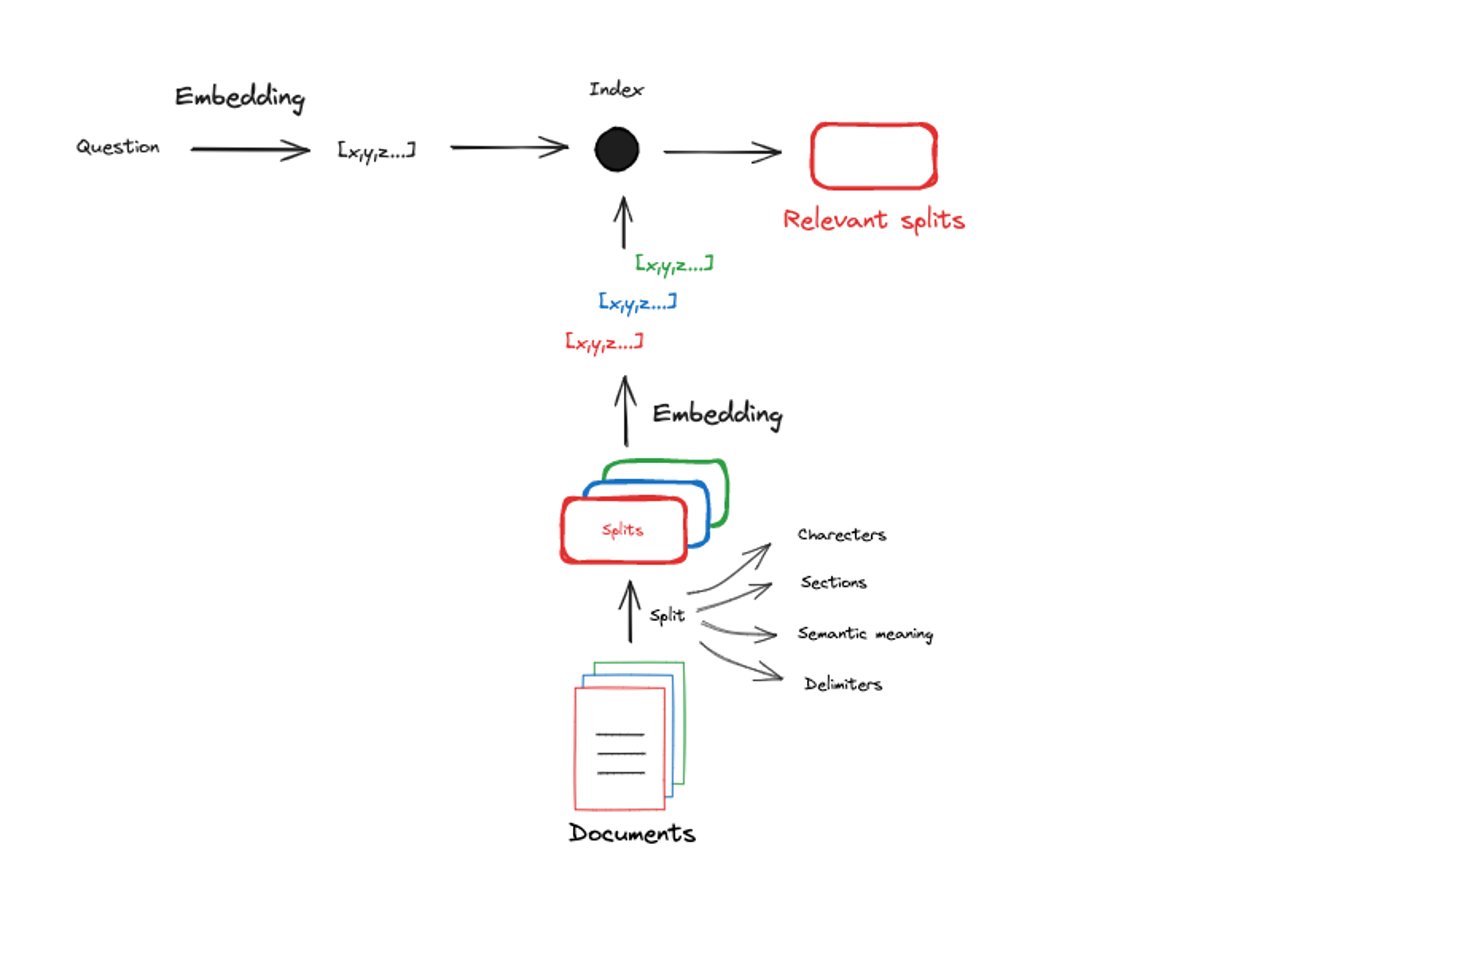

### Quick Token Counting Utility

In [39]:
def count_tokens(text: str, encoding_name: str = "cl100k_base") -> int:
    """Calculate the number of tokens in a given string."""
    encoding = tiktoken.get_encoding(encoding_name)
    return len(encoding.encode(text))


# Example usage
sample_question = "How is Greece's 2025 budget surplus being used?"
sample_document = "Greece announced €1 billion in financial benefits following a strong 2025 fiscal surplus."

print("Sample question tokens:", count_tokens(sample_question))

Sample question tokens: 12


### Embedding and Similarity Check

In [40]:
# Embed the query and document
question_embedding = embedder.embed_query(sample_question)
document_embedding = embedder.embed_query(sample_document)


# Define cosine similarity function
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    return dot_product / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


# Calculate similarity
similarity_score = cosine_similarity(question_embedding, document_embedding)
print("Cosine Similarity:", similarity_score)

Cosine Similarity: 0.6497082498220133


In [41]:
len(question_embedding)

384

In [42]:
question_embedding[:5]

[-0.10974527895450592,
 0.027172289788722992,
 -0.004165921825915575,
 -0.019714944064617157,
 0.058254290372133255]

# Controlling the number of documents returned

In [43]:
greece_retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

print(
    "Indexing completed. Retriever is ready to answer questions about the Greek economy."
)

Indexing completed. Retriever is ready to answer questions about the Greek economy.


In [44]:
docs = greece_retriever.invoke("What do you know about greek economy?")

In [45]:
len(docs)

1

In [46]:
docs = retriever.invoke("What do you know about greek economy?")

In [47]:
len(docs)

4

# Generation

In [48]:
chain = prompt | llm

In [49]:
# Run
chain.invoke({"context": docs, "question": "What do you know about greek economy?"})

AIMessage(content="According to the provided context, Moody's upgraded Greece's economy to investment grade, which is a significant development for the country. The upgrade highlights the rapid reduction of debt, increase in revenues, budget overperformance, and decline in non-performing loans.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1638, 'total_tokens': 1689, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.010348824000000006, 'prompt_time': 0.061781247, 'completion_time': 0.155030446, 'total_time': 0.216811693}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'id': 'chatcmpl-a76bd4ee-6fba-4dbf-8016-1853f011bd2f', 'finish_reason': 'stop', 'logprobs': None}, id='run-1cf0e481-9376-4182-a1fe-54f00699fdf8-0', usage_metadata={'input_tokens': 1638, 'output_tokens': 51, 'total_tokens': 1689, 'input_token_details': {}, 'output_token_details': {}})

In [50]:
prompt_hub_rag = hub.pull("rlm/rag-prompt")

In [51]:
print(prompt_hub_rag.messages[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [52]:
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What do you know about economy of Germany?")

"I don't know about the economy of Germany. The provided context is about the economy of Greece, not Germany."